In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import numpy as np
from torch import optim
from torch.utils.data import DataLoader, random_split, Dataset
from os.path import splitext
from os import listdir
import logging
from PIL import Image
import math
from scipy.ndimage.filters import convolve
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from torchvision import transforms
%matplotlib inline

### Defining the Neural Network

The following codes have been taken directly from https://github.com/milesial/Pytorch-UNet

In [2]:
class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=1):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

        if imgs_dir!='':
          self.ids = [splitext(file)[0] for file in listdir(imgs_dir) 
                      if not file.startswith('.')]
          logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    def preprocess(self, pil_img):
        w, h = pil_img.size
        newW, newH = int(self.scale * w), int(self.scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

In [3]:
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5,
                use_dense_crf=False):
    net.eval()

    ds = BasicDataset('', '', scale=scale_factor)
    orig_img = ds.preprocess(full_img)
    img = torch.from_numpy(orig_img)
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        if net.n_classes > 1:
            probs = F.softmax(output, dim=1)
        else:
            probs = torch.sigmoid(output)

        probs = probs.squeeze(0)

        tf = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(orig_img.shape[1]),
                transforms.ToTensor()
            ]
        )

        probs = tf(probs.cpu())
        full_mask = probs.squeeze().cpu().numpy()

    return full_mask > out_threshold

In [4]:
def plot_img_and_mask(img, mask):
    classes = mask.shape[2] if len(mask.shape) > 2 else 1
    fig, ax = plt.subplots(1, classes + 1)
    ax[0].set_title('Input image')
    ax[0].imshow(img)
    if classes > 1:
        for i in range(classes):
            ax[i+1].set_title(f'Output mask (class {i+1})')
            ax[i+1].imshow(mask[:, :, i])
    else:
        ax[1].set_title(f'Output mask')
        ax[1].imshow(mask)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [5]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [6]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(n_channels=3, n_classes=1)
net.load_state_dict(torch.load('unet.pth', map_location=device))

## Input and output of the neural network

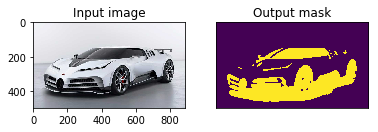

In [8]:
img = Image.open('bugatti-centodieci-feature-image.jpg')
mask = predict_img(net=net,
                           full_img=img,
                           scale_factor=1,
                           out_threshold=0,
                           use_dense_crf=False,
                           device=device)
plot_img_and_mask(img,mask)

### Taking a kernel from a layer and convolving it

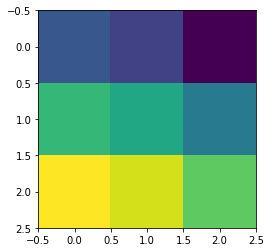

In [138]:
kernel = net.down4.maxpool_conv[1].double_conv[0].weight[6,5].cpu().data.numpy()
plt.imshow(kernel)

### Grayscale

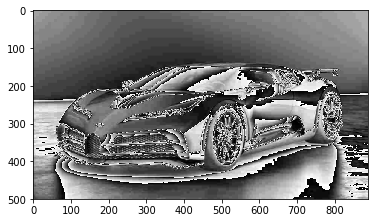

In [137]:
img = np.dot(imread("bugatti-centodieci-feature-image.jpg"), [0.3333, 0.3333, 0.3333]).astype('uint8')

kernels = net.down4.maxpool_conv[1].double_conv[0].weight[6,5].cpu().data.numpy()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()

res = convolve(img, kernels)

plt.imshow(res,cmap='gray')
plt.show()

### RGB

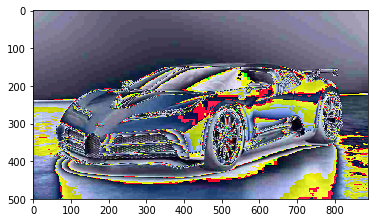

In [139]:
img = imread("bugatti-centodieci-feature-image.jpg")

kernels = net.down4.maxpool_conv[1].double_conv[0].weight[6,5].cpu().data.numpy()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()

channels = []
for channel in range(3):
    res = convolve(img[:,:,channel], kernels)
    channels.append(res)

img = np.dstack((channels[0], channels[1], channels[2]))

plt.imshow(img)
plt.show()

# Stacking the kernels and visualizing

All the kernels will stacked and visualized, below is a sample.

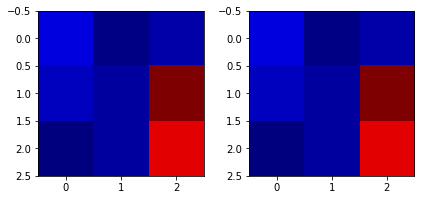

In [37]:
kernels = net.down4.maxpool_conv[1].double_conv[0].weight.detach().clone()
image = kernels[0]
for i in range(1,kernels.shape[0]):
    image = np.dstack((image,kernels[i]))
img = torch.from_numpy(image).permute(0,2,1)

#First kernel
plt.subplot(1, 2, 1)
plt.imshow(torch.t(kernels[0][0]), cmap='jet')
plt.subplot(1, 2, 2)

#First 3x3 pixels of the image
plt.imshow(img[0][:3,:], cmap='jet')
plt.tight_layout()
plt.show()

In [69]:
def normalization(x):
    x = x - x.min()
    return x /x.max()

def visualize_kernel(x,orientation='v',color='gray',normalize=True):
    '''
    x => Weight of the Convolutional layer
    orientation => h : kernels are horizontally stacked/ v : kernels are vertically stacked
    color => color map of the plot
    normalize => choose if you want to normalize the kernels before plotting
    '''
    if normalize:
        kernels = normalization(x)
    else:
        kernels = x
    image = kernels[0]
    for i in range(1,kernels.shape[0]):
        image = np.dstack((image,kernels[i]))
    img = torch.from_numpy(image).permute(0,2,1)
    if orientation=='v':
        plt.imshow(np.vstack((img[:,:,0],img[:,:,1],img[:,:,2])),cmap=color)
    else:
        plt.imshow(np.hstack((img[:,:,0],img[:,:,1],img[:,:,2])),cmap=color)
        
def visualize_upkernel(x,orientation='v',color='gray',normalize=True):
    '''
    x => Weight of the Convolutional layer
    orientation => h : kernels are horizontally stacked/ v : kernels are vertically stacked
    color => color map of the plot
    normalize => choose if you want to normalize the kernels before plotting
    '''
    if normalize:
        kernels = normalization(x)
    else:
        kernels = x
    image = kernels[0]
    for i in range(kernels.shape[0]):
        image = np.hstack((image,kernels[i]))
    if orientation=='v':
        plt.imshow(np.vstack((image[:,:,0],image[:,:,1])),cmap=color)
    else:
        plt.imshow(np.hstack((image[:,:,0],image[:,:,1])),cmap=color)

### Down Layers

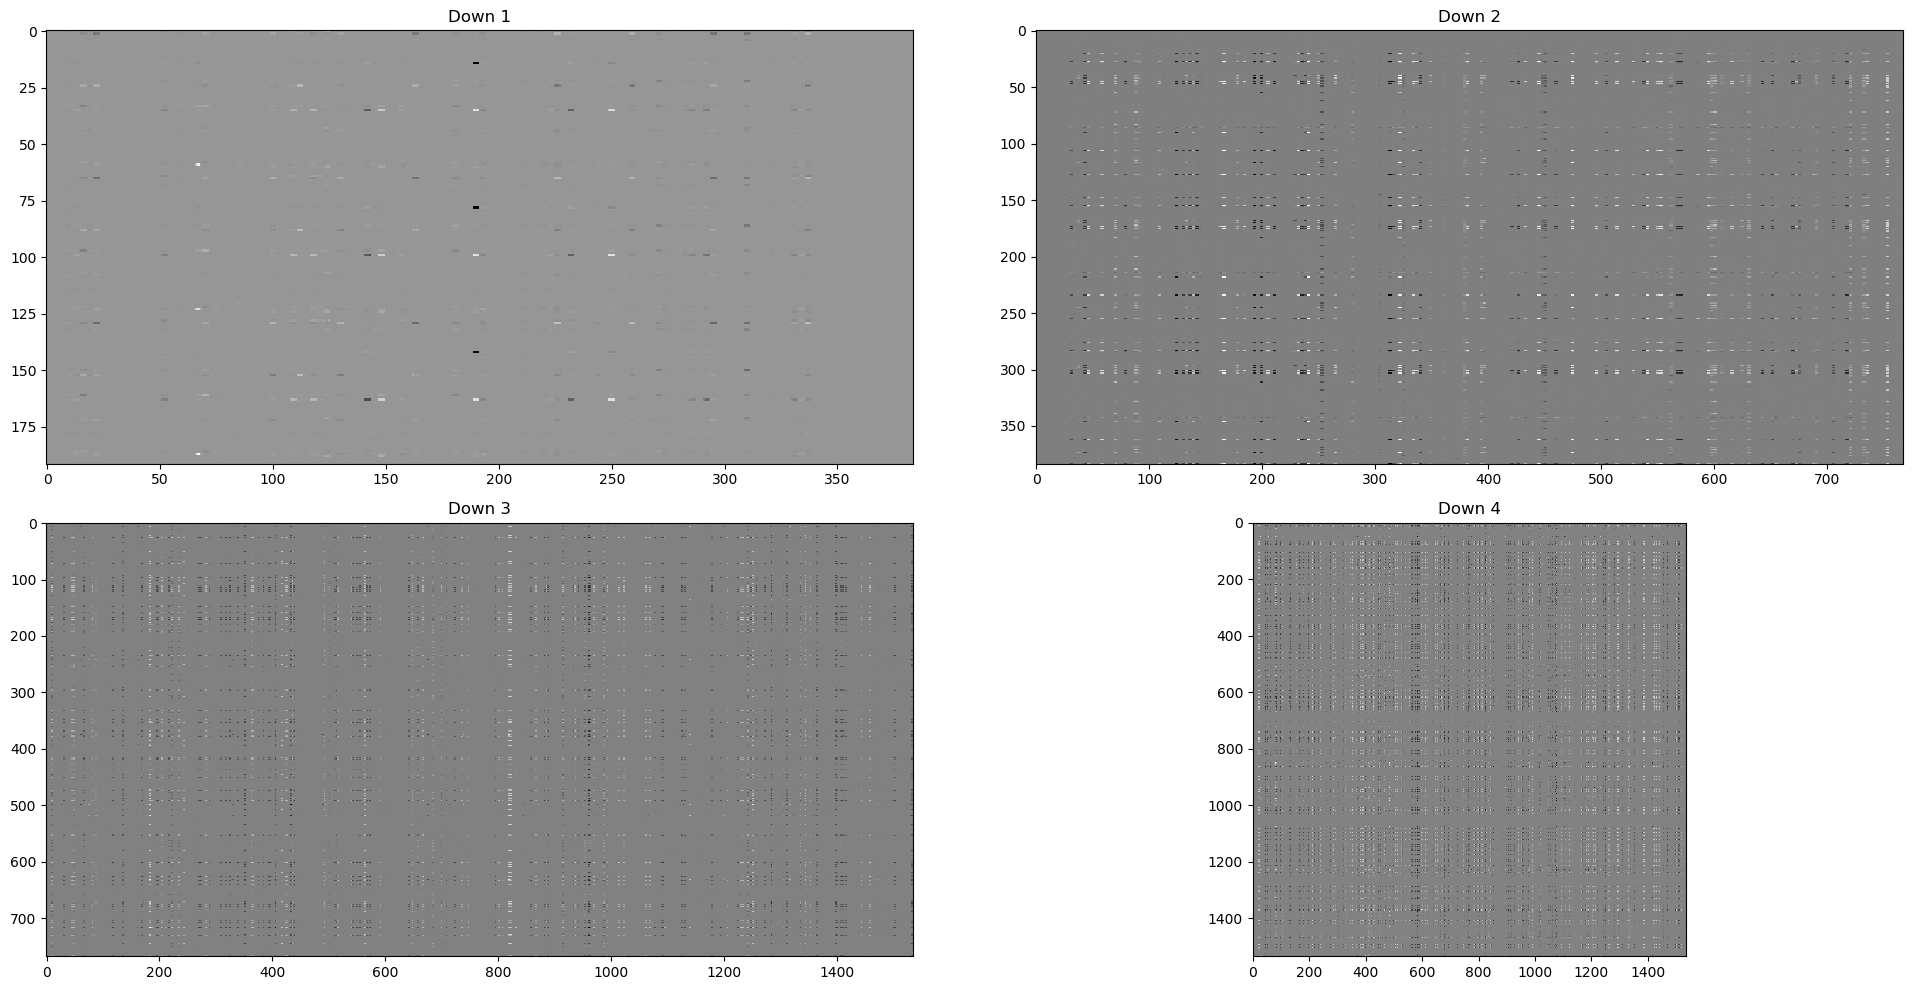

In [68]:
plt.figure(figsize=(20,10), dpi=100)

plt.subplot(2, 2, 1)
visualize_kernel(net.down1.maxpool_conv[1].double_conv[0].weight.detach().clone())
plt.title('Down 1')

plt.subplot(2, 2, 2)
visualize_kernel(net.down2.maxpool_conv[1].double_conv[0].weight.detach().clone())
plt.title('Down 2')


plt.subplot(2, 2, 3)
visualize_kernel(net.down3.maxpool_conv[1].double_conv[0].weight.detach().clone())
plt.title('Down 3')


plt.subplot(2, 2, 4)
visualize_kernel(net.down4.maxpool_conv[1].double_conv[0].weight.detach().clone())
plt.title('Down 4')


plt.tight_layout()
plt.show()

### Convolution layer of the Up layers

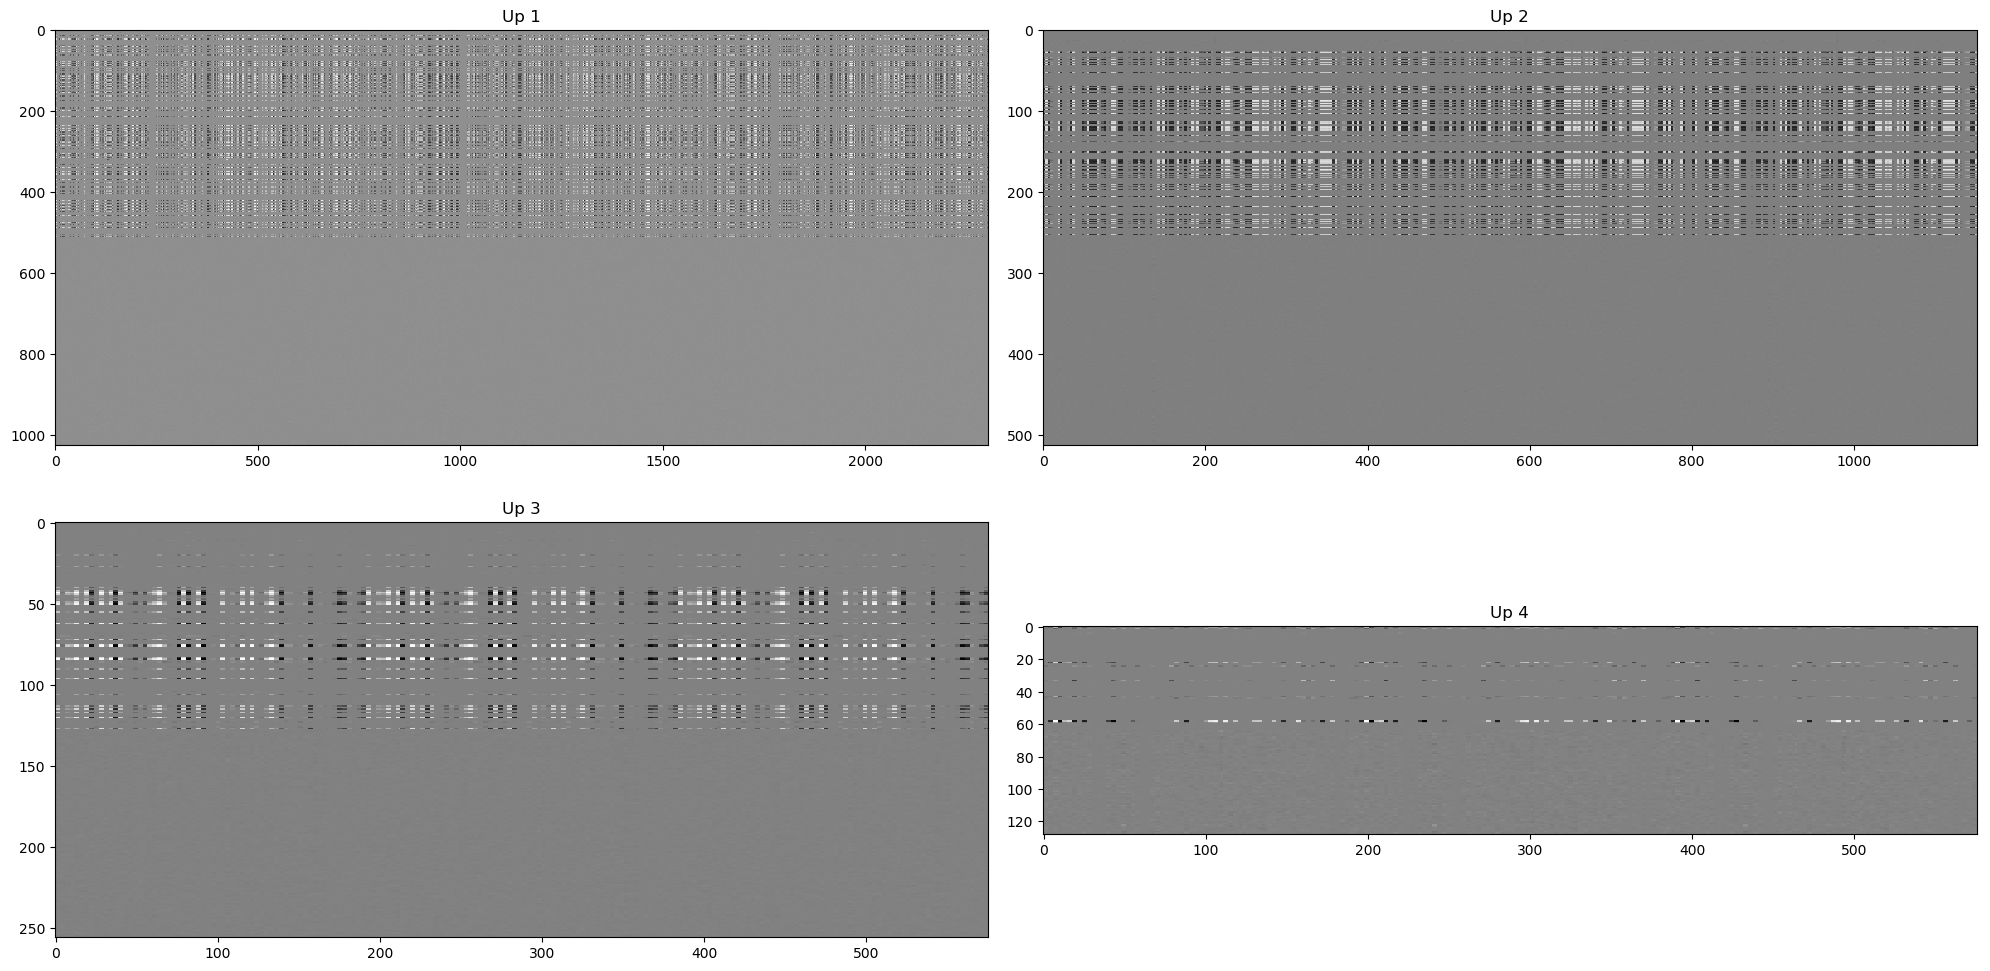

In [64]:
plt.figure(figsize=(20,10), dpi=100)

plt.subplot(2, 2, 1)
visualize_kernel(net.up1.conv.double_conv[0].weight.detach().clone(),orientation='h')
plt.title('Up 1')

plt.subplot(2, 2, 2)
visualize_kernel(net.up2.conv.double_conv[0].weight.detach().clone(),orientation='h')
plt.title('Up 2')


plt.subplot(2, 2, 3)
visualize_kernel(net.up3.conv.double_conv[0].weight.detach().clone(),orientation='h')
plt.title('Up 3')


plt.subplot(2, 2, 4)
visualize_kernel(net.up4.conv.double_conv[0].weight.detach().clone(),orientation='h')
plt.title('Up 4')


plt.tight_layout()
plt.show()

### Transposed Convolution layer of the Up layers

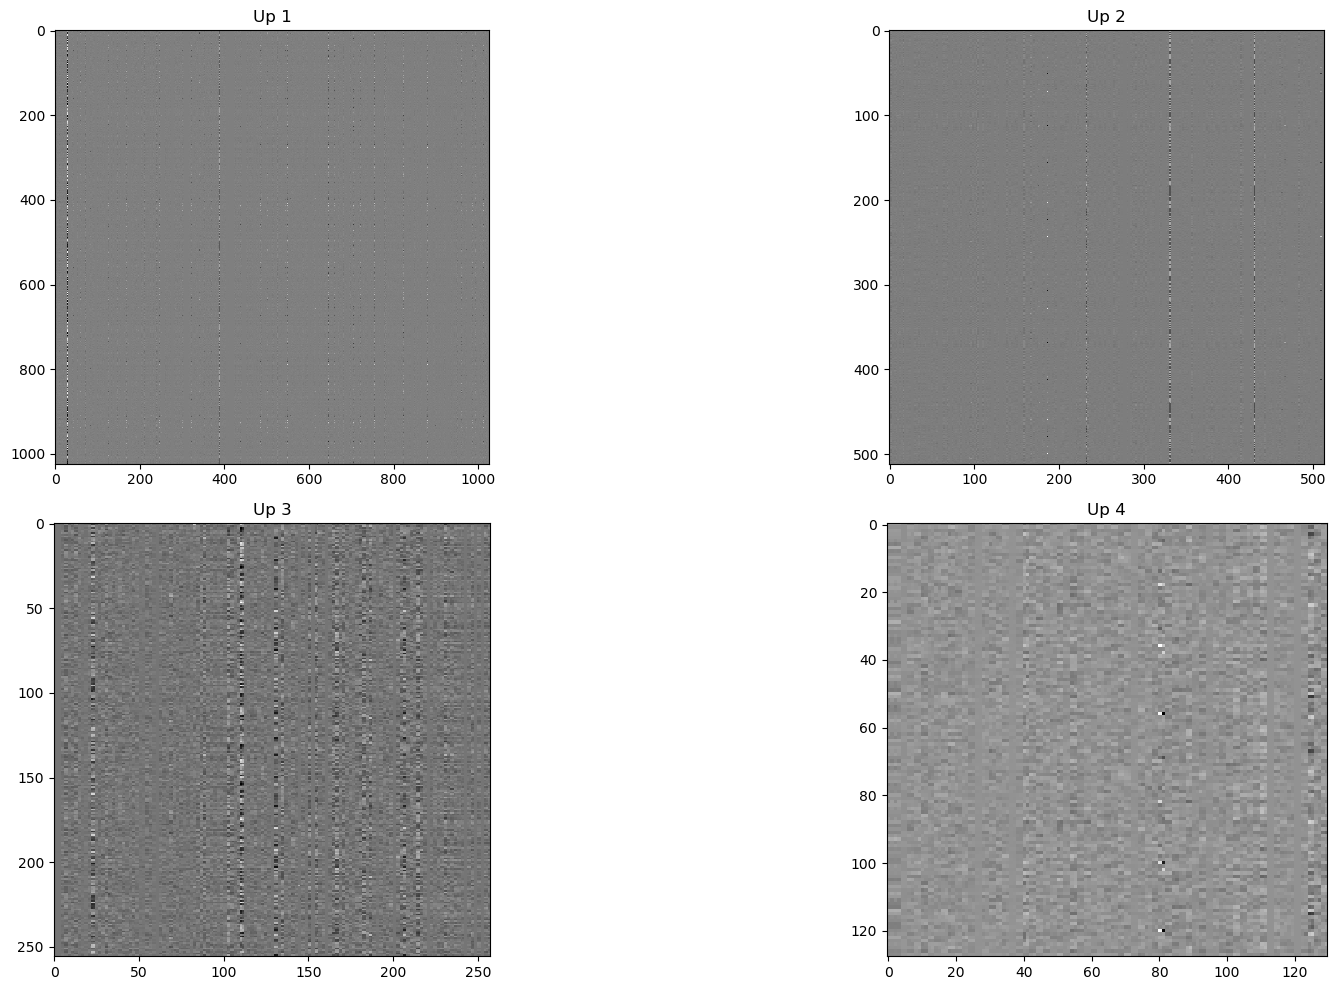

In [72]:
plt.figure(figsize=(20,10), dpi=100)

plt.subplot(2, 2, 1)
visualize_upkernel(net.up1.up.weight.detach().clone())
plt.title('Up 1')

plt.subplot(2, 2, 2)
visualize_upkernel(net.up2.up.weight.detach().clone())
plt.title('Up 2')


plt.subplot(2, 2, 3)
visualize_upkernel(net.up3.up.weight.detach().clone())
plt.title('Up 3')


plt.subplot(2, 2, 4)
visualize_upkernel(net.up4.up.weight.detach().clone())
plt.title('Up 4')


plt.tight_layout()
plt.show()

# Visualizing Feature Maps

In [140]:
def get_features(layer,img):
    outputs= []
    def hook(module, input, output):
        outputs.append(output)
    h = layer.register_forward_hook(hook)
    mask = predict_img(net=net,
                               full_img=img,
                               scale_factor=1,
                               out_threshold=0,
                               use_dense_crf=False,
                               device=device)
    return outputs

def show_features(features,max_plots,max_tensor=10,color='jet'):
    '''
    features => features from the U-net
    max_plots => Maximum number of plots you want
    max_tensor => If a feature crosses this tensor.max() threshold, then the feature is plotted
    color => colormap of the plot
    '''
    number_of_features = features[0].shape[1]
    output_features=[]
    for i in range(number_of_features):
        if features[0][0][i].max()>max_tensor:
            output_features.append(features[0][0][i])
            
    total_plot = int(max_plots/2)
    total_features = len(output_features)

    ct=1
    
    for row in range(total_plot):
        for col in range(total_plot):
            if ct-1<total_features:
                plt.subplot(total_plot,total_plot,ct)
                plt.axis('off')
                plt.imshow(output_features[ct-1],cmap='jet')
                ct+=1
            else:
                break
            
    plt.show()

### Feature map of a Down Layer

In [129]:
img = Image.open('bugatti-centodieci-feature-image.jpg')
features = get_features(net.down4.maxpool_conv[1].double_conv,img)

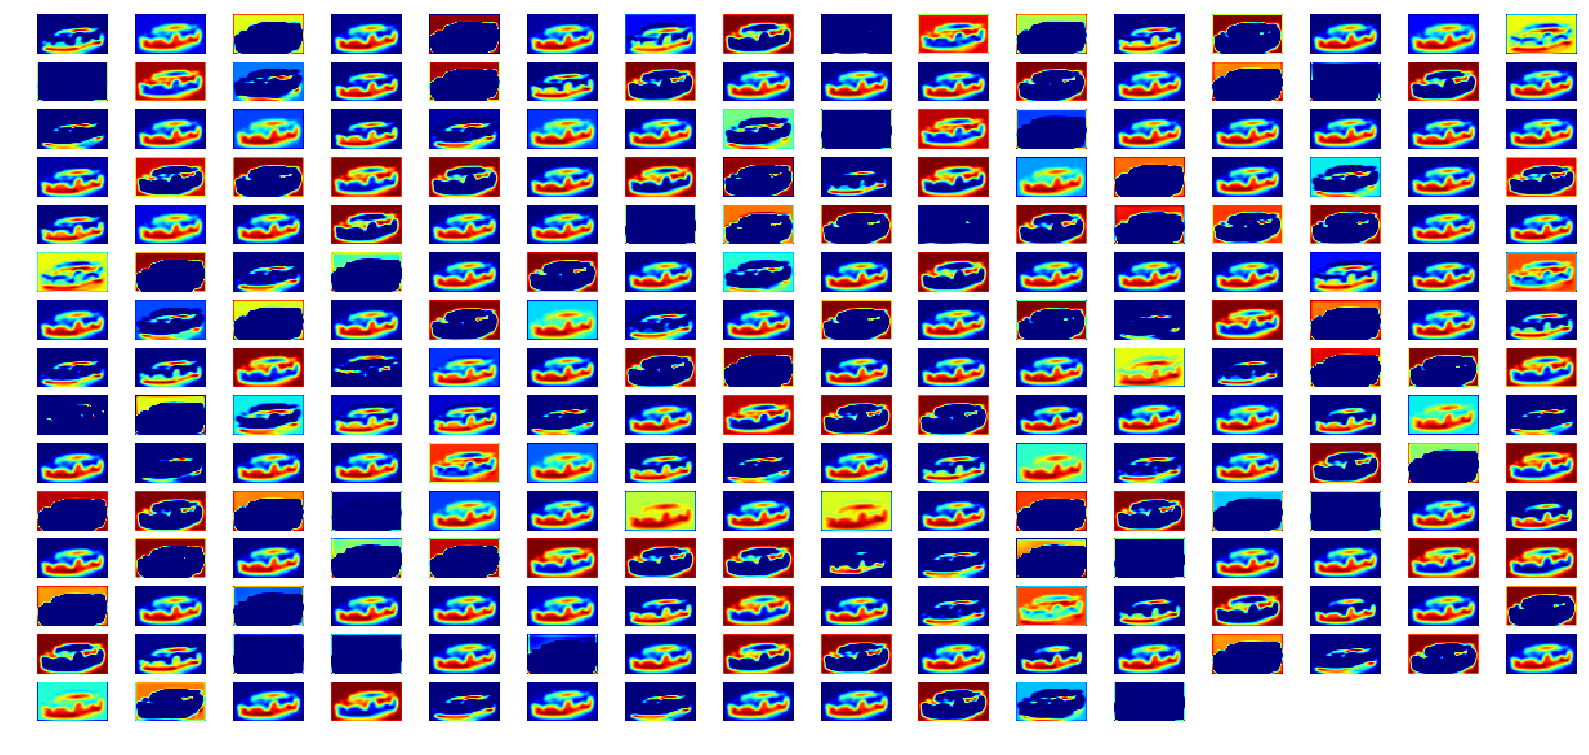

In [130]:
plt.figure(figsize=(20,10), dpi=100)

show_features(features,32)

### Feature map of an Up layer

In [132]:
features = get_features(net.up2.conv.double_conv,img)

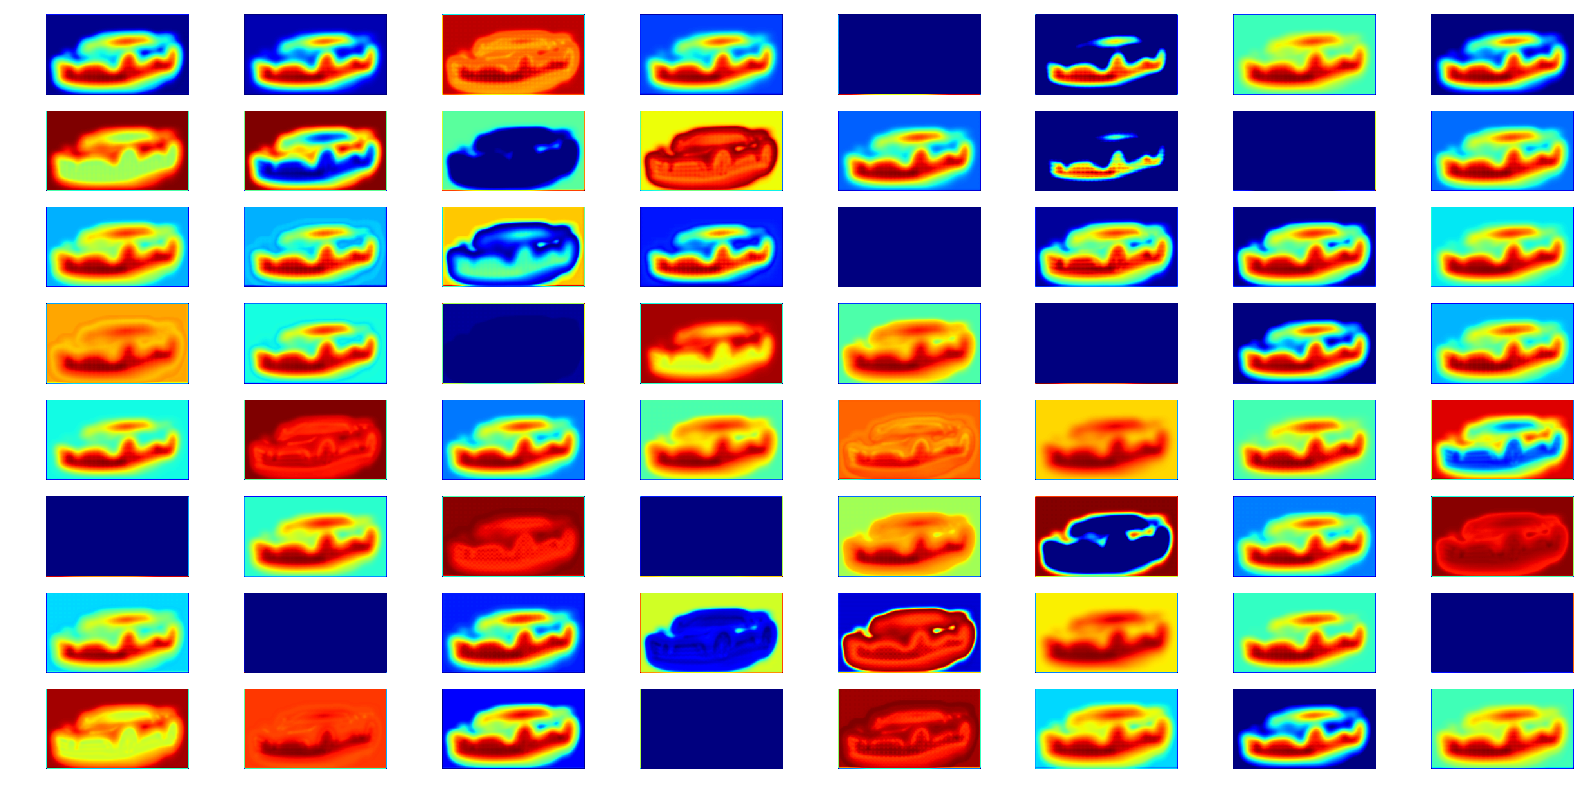

In [141]:
plt.figure(figsize=(20,10), dpi=100)

show_features(features,16,max_tensor=5)